We train a sequence to sequence model on Amazon Food reviews dataset. The input sequence are food reviews and output sequence are title for the reviews. We have a stack of three LSTMs as encoder with the third LSTM being a Bidirectional LSTM. We use LSTM along with Bahandanau's attention as our decoder. We use a custom attention.py file to implement Attention. We extend the work in this [article](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)  using Bidirectional LSTMs and Beam Search as a decoder. We tried using Rogue score to evaluate our model but since the length of summaries are typically very small. Rogue score may not be suitable for this problem.

In [1]:
# Import libraries

from attention import AttentionLayer
%matplotlib inline
import nltk
nltk.download('stopwords')
from tensorflow.keras import backend as K


import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nightshade/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read the dataset
This dataset consists of reviews of fine foods from Amazon. The data spans a period of more than 10 years, including all ~500,000 reviews up to October 2012. These reviews include product and user information, ratings, plain text review, and summary. It also includes reviews from all other Amazon categories.

We train our model on 100,000 training samples to reduce the computational overhead on the GPU. Using more samples leads to memory allocation error on DSMLP.

In [2]:
data=pd.read_csv("Reviews.csv", nrows=100000)

### Drop Duplicates and NA values

In [3]:
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)#dropping na
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


# Information about dataset

Let us look at datatypes and shape of the dataset

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
Id                        88421 non-null int64
ProductId                 88421 non-null object
UserId                    88421 non-null object
ProfileName               88421 non-null object
HelpfulnessNumerator      88421 non-null int64
HelpfulnessDenominator    88421 non-null int64
Score                     88421 non-null int64
Time                      88421 non-null int64
Summary                   88421 non-null object
Text                      88421 non-null object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


### Preprocessing

We perform basic preprocessing on the the text data to clean them. We use the below dictionary to expand our contractions.

In [5]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We will perform the below preprocessing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove short words


In [6]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [7]:
# Clean reviews data
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0)) 

Let us look at the first five preprocessed reviews

In [8]:
cleaned_text[:5]  

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [9]:
#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

Let us look at the first 10 preprocessed summaries

In [10]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [11]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

#Drop empty rows

In [12]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

### Distibution of the sequences

We analyze the length of the reviews and the summary to estimate the distribution of the sequence length for reviews and titles. This helps us to decide the maximum sequence length for both reviews and titles.

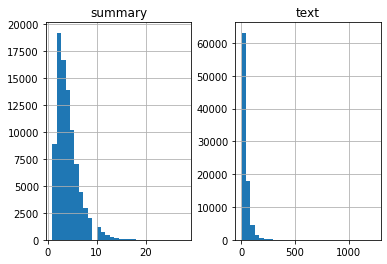

In [13]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

Interesting. We can fix the maximum length of the summary to 8 since that seems to be the majority summary length.

Let us understand the proportion of the length of summaries below 8

In [14]:
cnt=0
text_len = 30
sum_len = 8
for i in data['cleaned_summary']:
    if(len(i.split())<=sum_len):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9424907471335922


We observe that 94% of the summaries have length below 8. So, we can fix maximum length of summary to 8.

Similarly fixing the maximum length of review to 60 seems sound.

In [15]:
max_text_len=60
max_summary_len=8

Let us select the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [16]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})
df.head()

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,not as advertised
2,confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,delight says it all
3,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,cough medicine
4,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy


Next we will add start and end tokens at the beginning and end of each summary in the datset. Make sure that this tokens don't exist in our vocabulary.

In [17]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

We split the data into training and validation set. We use the validation set to decide later when to stop training. (Early Stopping).

In [18]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

### Tokenizer
A tokenizer builds the vocabulary and converts a word sequence to an integer sequence. 

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

### Rarewords and its Coverage

We look at the proportion of the rare words and their coverage.

We define threshold as 4 which means word whose count is below 4 is considered as a rare word

In [20]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq))
print(tot_cnt-cnt)

% of rare words in vocabulary: 64.82931071972168
Total Coverage of rare words: 0.019653016182939027
12940



* **tot_cnt** gives the size of vocabulary (which means every unique words in the text)
 
*   **cnt** gives me the no. of rare words whose count falls below threshold

*  **tot_cnt - cnt** gives me the top most common words 

Let us define the tokenizer with top most common words for reviews.

In [21]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

### Tokenizer for Summaries (titles)

In [22]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

### Rarewords and its Coverage

Proportion rare words and its total coverage in the entire summary

Threshold is 6 which means word whose count is below 6 is considered as a rare word

In [23]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 76.74038378797006
Total Coverage of rare words: 4.3293281055378


Define a tokenizer with the top most frequent words 

In [24]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1


Delete rows that contain only **START** and **END** tokens

In [25]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [26]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# Model 

We define a sequence to sequence model using a encoder-decoder architecture. We use a Embedding Matrix and a stack of three LSTMs as our encoder. The third LSTM is Bidirectional LSTM. The decoer is an LSTM decoder along with Bahadanau's attention. 
We use sparse categorical crossentropy as our loss since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.


In [27]:
from tensorflow.keras import backend as K 

K.clear_session()
def build_model(latent_dim=128, embedding_dim=100):


    # Encoder
    encoder_inputs = Input(shape=(max_text_len,))

    #encoder embedding layer
    enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

    #encoder lstm 1
    encoder_lstm1 = LSTM(latent_dim,return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
    encoder_output1 = encoder_lstm1(enc_emb)

    #encoder lstm 2
    encoder_lstm2 = LSTM(latent_dim,return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
    encoder_output2 = encoder_lstm2(encoder_output1)

    #encoder lstm 3 Bidirectional LSTM
    encoder_lstm3=Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4), merge_mode='concat')
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm3(encoder_output2)
    
    # Concatenate the histories and cell state from both directions
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])



    decoder_inputs = Input(shape=(None,))

    # decoder embedding layer
    dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
    dec_emb = dec_emb_layer(decoder_inputs)

    # decoder lstm
    decoder_lstm = LSTM(2*latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
    decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(dec_emb,initial_state=[state_h, state_c])


    # Attention layer
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])



    # Concat attention input and decoder LSTM output
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

    #dense layer
    decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_concat_input)

    # Define the model 
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    return model

model = build_model()

model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 100)      1294100     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 60, 128)      117248      embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 60, 128)      131584      lstm[0][0]                       
______________________________________________________________________________________________

In [28]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [29]:
# Checkpoint to save model with the best performance on validation set
file_path2 = "./pretrained_models/model_best_val.h5"
cp2 = ModelCheckpoint(file_path2, monitor='val_loss', verbose=1, save_best_only=True, mode='min')



We’ll train the model on a batch size of 128 and validate it on the holdout set (which is 10% of our dataset):

In [30]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=1,callbacks=[cp2],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 62511 samples, validate on 6932 samples
62464/62511 [============================>.] - ETA: 0s - loss: 3.1116
Epoch 00001: val_loss improved from inf to 2.80949, saving model to ./pretrained_models/model_best_val.h5
62511/62511 [==============================] - 452s 7ms/sample - loss: 3.1113 - val_loss: 2.8095


In [31]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('model_history.csv')